In [7]:
from preprocessing import *
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn import metrics

# Input
Xp,ids=prot_feats('./dataset/Training_Positive_Original_488.fasta')
Xn,ids=prot_feats('./dataset/Training_Negative_902.fasta')
yp=np.array([1]*Xp.shape[0])
yn=np.array([-1]*Xn.shape[0])

X = np.concatenate((Xp, Xn))
y = np.concatenate((yp, yn))

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)


In [9]:
## Tuning Hyperparameters
# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# grid = dict(C=param_grid['C'], gamma = param_grid['gamma'], kernel = param_grid['kernel'])

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# grid_search = GridSearchCV(estimator=SVC(), param_grid=grid, n_jobs=-1, cv=cv, scoring='precision', error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [10]:
# Training
model = GaussianNB()
model.fit(X_train, y_train)
pickle.dump(model, open('./model/svc_nb.pickle', 'wb'))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
y_pred = model.predict(X_test)

(972, 412) (417, 412) (972,) (417,)


[[144 127]
 [ 14 132]]
144 127 14 132


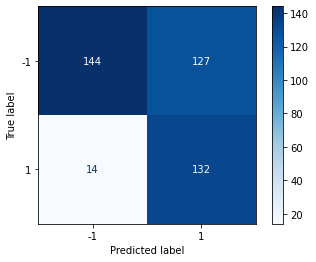

Sensitivity =  0.9041095890410958
Specificity =  0.5096525096525096
Accuracy =  0.6618705035971223
F-value =  0.6518518518518519


In [11]:
# Evaluate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_test, y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

print('Sensitivity = ', tp/(tp+fn))
print('Specificity = ', tp/(tp+fp))
print('Accuracy = ', (tp+tn)/(tp+fp+tn+fn))
print('F-value = ', 2*tp/(2*tp+fp+fn))

# print(sklearn.metrics.accuracy_score(y_test, y_pred))
# print(sklearn.metrics.precision_score(y_test, y_pred))
# print(sklearn.metrics.recall_score(y_test, y_pred))
# print(sklearn.metrics.f1_score(y_test, y_pred), end='\n\n')


In [12]:
## XGBoost Ranker
# from xgbranker import XGBRanker
# model = XGBRanker(n_estimators=120, learning_rate=0.1, subsample=0.6, max_tree_depth=3)
# model.fit(X_train, y_train)
# pickle.dump(model, open('xgb.pickle', 'wb'))
# model.decision_function = model.predict
# y_pred = model.decision_function(X_test)
# for i, value in enumerate(y_pred):
#     if value > 0:
#         y_pred[i] = 1
#     else:
#         y_pred[i] = -1
# print(sklearn.metrics.accuracy_score(y_test, y_pred))
# print(sklearn.metrics.precision_score(y_test, y_pred))
# print(sklearn.metrics.recall_score(y_test, y_pred))
# print(sklearn.metrics.f1_score(y_test, y_pred))

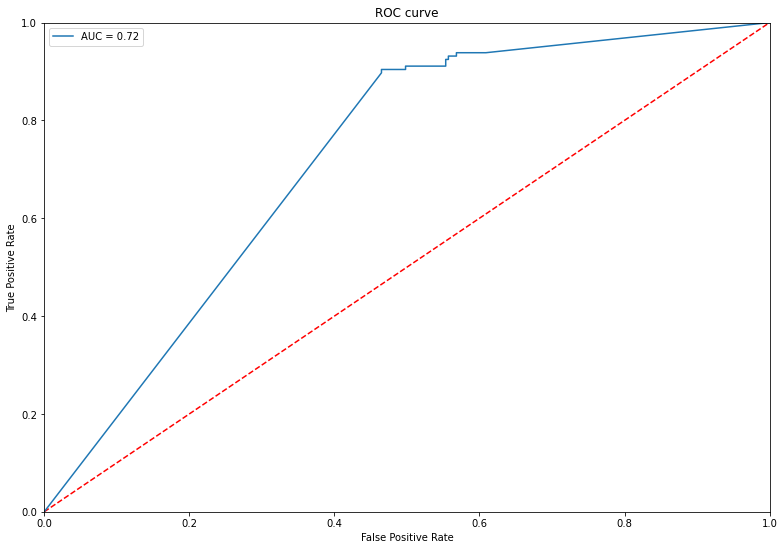

In [13]:
# AUC-ROC
fig = plt.figure(figsize=(13,9))
plt.plot([0, 1], [0, 1],'r--')

predict_pobs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, predict_pobs)
auc = metrics.roc_auc_score(y_test, predict_pobs)
plt.plot(fpr, tpr, label=f'AUC = {str(round(auc,3))}')

# Plot
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [9]:
# # Evaluate by CV
# from sklearn.model_selection import KFold, RepeatedStratifiedKFold, cross_val_score
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=2)
# scores = cross_val_score(estimator=SVC(), X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# for score in scores:
#     print('Accuracy: %.3f' % score)
# print('Mean: %.3f, Std: %.3f' % (np.mean(scores), np.std(scores)))